In [1]:
import pathlib
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from __future__ import division, print_function, unicode_literals, absolute_import

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

In [4]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_dataset.head()

dataset = raw_dataset.copy()
dataset = dataset.dropna()

#one hot encoding

origins = dataset.pop("Origin")
dataset["USA"] = (origins == 1) * 1.0
dataset["Europe"] = (origins == 2) * 1.0
dataset["Japan"] = (origins == 3) * 1.0
dataset.tail()


dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


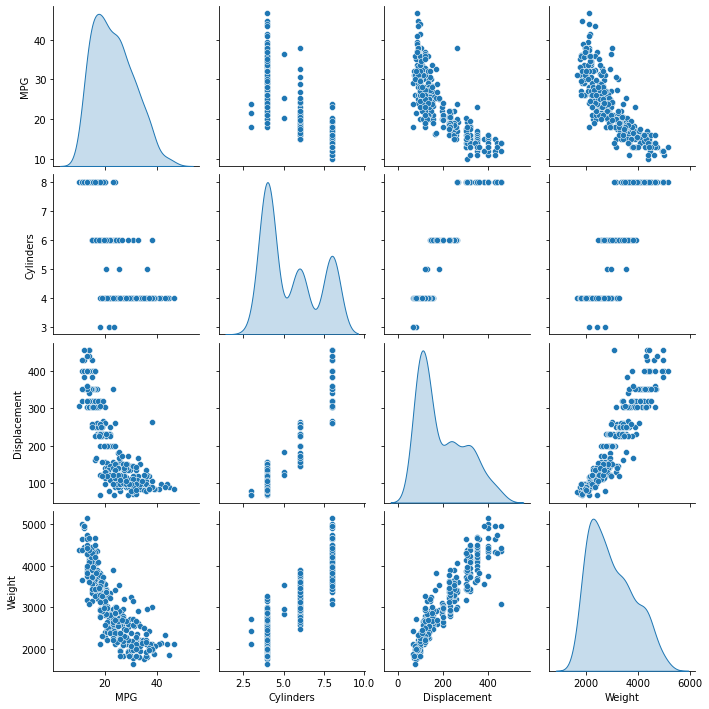

In [5]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [6]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")


In [7]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
test_labels.head()

9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
Name: MPG, dtype: float64

In [9]:
def normalize(x):
    return (x - train_stats["mean"]) / train_stats["std"]

In [11]:
normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

normed_test_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,8,390.0,190.0,3850.0,8.5,70,1.0,0.0,0.0
25,8,360.0,215.0,4615.0,14.0,70,1.0,0.0,0.0
28,8,304.0,193.0,4732.0,18.5,70,1.0,0.0,0.0
31,4,113.0,95.0,2228.0,14.0,71,0.0,0.0,1.0
33,6,232.0,100.0,2634.0,13.0,71,1.0,0.0,0.0


In [12]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])
    
    opti = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',
                optimizer=opti,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [13]:
model = build_model()

2022-10-11 18:50:14.041386: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-11 18:50:14.045744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
example_batch = normed_train_data[:10]

In [17]:
example_predict = model.predict(example_batch)
example_predict

2022-10-11 19:03:11.192644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


array([[0.33495715],
       [0.41819865],
       [0.7488879 ],
       [0.8240513 ],
       [0.10291921],
       [0.46669322],
       [0.1834318 ],
       [0.8009224 ],
       [0.42235094],
       [0.15095527]], dtype=float32)

In [18]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
        
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.470279,0.969203,2.470279,9.598804,2.277628,9.598804,995
996,2.632548,1.014385,2.632548,9.957215,2.327248,9.957215,996
997,2.618545,1.018669,2.618545,9.738041,2.360279,9.738041,997
998,2.539464,0.985014,2.539464,9.994086,2.370650,9.994086,998
999,2.792739,1.048228,2.792739,9.859546,2.353088,9.859546,999


In [25]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
               label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
               label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

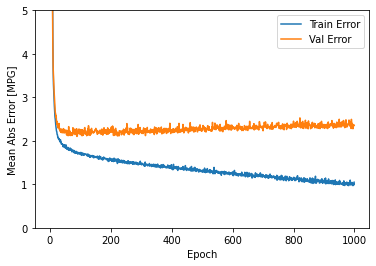

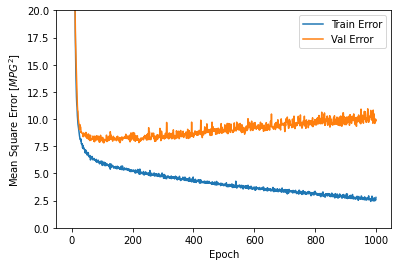

In [26]:
plot_history(history)

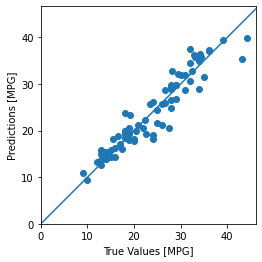

In [27]:
test_predictions = model.predict(normed_test_data).flatten()
 
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

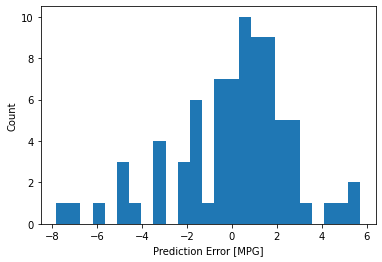

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")